<a href="https://colab.research.google.com/github/pjwu1997/FinancialEngineering/blob/master/HW5/Hull_White_Model_Option_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install QuantLib-Python

In [0]:
import QuantLib as ql

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# State Variables
T = float(input("請輸入該選擇權之到期時間(年):"))
timestep = int(T*360) # One day
N = 100 # Path

print("")
print("以下變數sigma,a用於定義Hull-White Model:")
sigma_hw = float(input("sigma in Hull-White Model:"))
a = float(input("a in Hull-White Model:"))
print("")
print("以下定義選擇權之相關變數:")
print("")
sigma_op = float(input("請輸入選擇權之波動度:"))
S0 = float(input("請輸入股票目前之價格:"))
K = float(input("請輸入履約價:"))
print("")

#print("請輸入term structure,自開始到結束時間之10期遠期利率:")
#term_structure = []
#for i in range(10):
    #term_structure.append(float(input("請輸入至時間"+str((i+1)*T/10)+"年之遠期利率:")))
forward_r = float(input("假設Forward rate為水平,輸入遠期利率值"))


請輸入該選擇權之到期時間(年):3

以下變數sigma,a用於定義Hull-White Model:
sigma in Hull-White Model:0.1
a in Hull-White Model:0.1

以下定義選擇權之相關變數:

請輸入選擇權之波動度:0.3
請輸入股票目前之價格:50
請輸入履約價:50

假設Forward rate為水平,輸入遠期利率值0.05


In [0]:
#Hull-White Process
np.random.seed(1)
#timestep = 360
length = T
forward_rate = forward_r
day_count = ql.Thirty360()
todays_date = ql.Date(12,5,2020)

ql.Settings.instance().evaluationDate = todays_date

spot_curve = ql.FlatForward(todays_date,ql.QuoteHandle(ql.SimpleQuote(forward_rate)),day_count)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)
hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma_hw)
rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(timestep,ql.UniformRandomGenerator()))
seq = ql.GaussianPathGenerator(hw_process,length,timestep,rng,False)

In [8]:
seq

<QuantLib.QuantLib.GaussianPathGenerator; proxy of <Swig Object of type 'PathGenerator< GaussianRandomSequenceGenerator > *' at 0x7f9897a47840> >

In [0]:
def generate_paths(num_paths,timestep):
    arr = np.zeros((num_paths,timestep+1))
    for i in range(num_paths):
        sample_path = seq.next()
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))]
        value = [path[j] for j in range(len(path))]
        arr[i,:] = np.array(value)
    return np.array(time), arr

In [10]:
num_paths = int(input("要跑幾次模擬:"))
time, paths = generate_paths(num_paths, timestep)
#for i in range(num_paths):
    #plt.plot(time, paths[i,:], lw=0.8, alpha=0.6)
#plt.title("Hull-White Short Rate Simulation")
#plt.show()
#paths

要跑幾次模擬:100


In [0]:
# Generation of Brownian Motion Path
def genBrownPath(T, mu, sigma, S0, dt):
    n = round(T/dt)
    t = np.linspace(0,T,n)
    W = [0] + np.random.standard_normal(size = n)
    W = np.cumsum(W)*np.sqrt(dt)
    dt_seq = np.array([dt]*n)
    X = np.cumsum(mu*dt_seq)
    S = S0*np.exp(X)
    #plt.plot(t,S)
    return S

In [0]:
paths.shape

(100, 1081)

In [12]:
# Generation of stock price curve
stock_paths = np.zeros((num_paths,timestep))

for i in range(num_paths):
    tmp_path = paths[i][:-1]
    stock_paths[i] = genBrownPath(T,tmp_path,sigma_op,S0,float(1/360))

# Calculate call/put price
def calc_op(stock_paths,K):
    call_price = 0
    put_price = 0
    for i in range(len(stock_paths)):
        stock_price = stock_paths[i][-1]
        if(stock_price > K):
            call_price += (stock_price - K) * np.exp(-forward_r * T)
        elif(stock_price < K):
            put_price += (K - stock_price) * np.exp(-forward_r * T)
    call_price = call_price / len(stock_paths)
    put_price = put_price / len(stock_paths)
    return call_price,put_price

call_price,put_price = calc_op(stock_paths,K)

print("Call price =",call_price)
print("Put price =",put_price)

Call price = 13.07993517113436
Put price = 1.6584893330592139


100 times ran
100 times ran
100 times ran


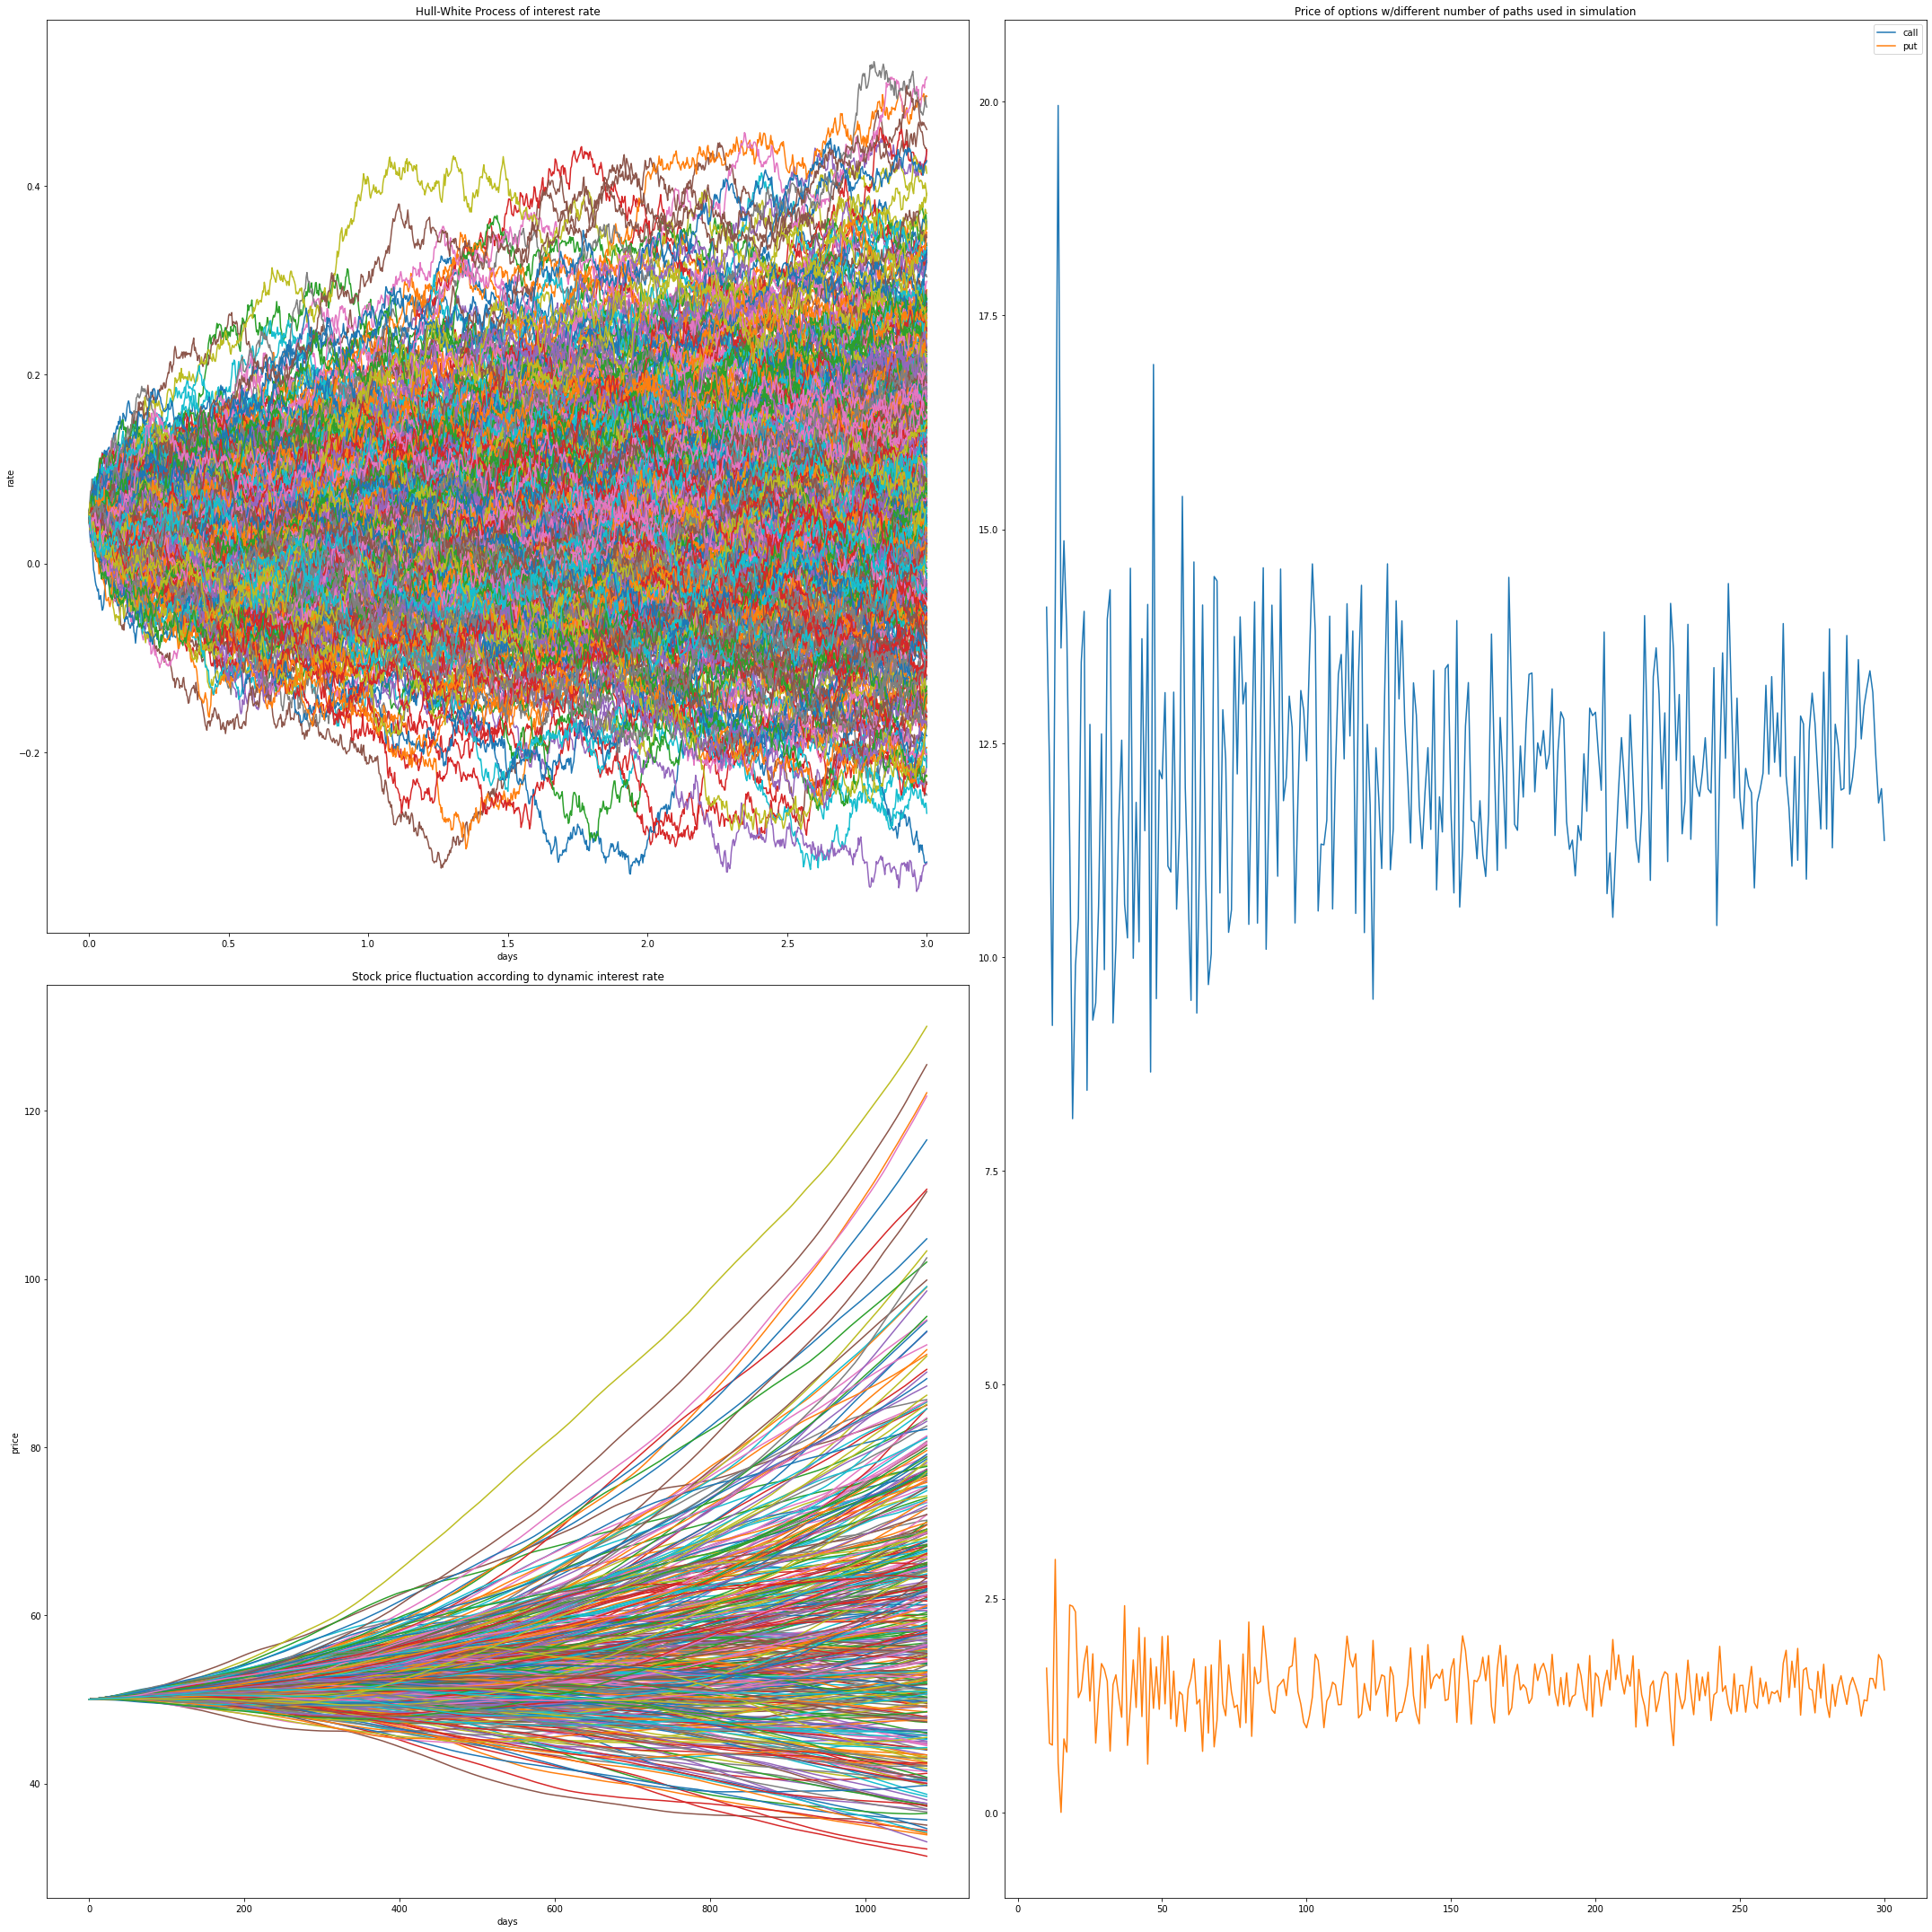

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30,30))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,3)
for i in range(len(paths)):
    ax1.plot(time,paths[i])
    ax2.plot(stock_paths[i])
ax1.set_title("Hull-White Process of interest rate")
ax1.set_xlabel("days")
ax1.set_ylabel("rate")
ax2.set_title("Stock price fluctuation according to dynamic interest rate")
ax2.set_xlabel("days")
ax2.set_ylabel("price")

ax3 = plt.subplot(1,2,2)

call_lst = []
put_lst = []
num_array= np.arange(10,301)
for i in num_array:
    if(i%100 == 0):
        print('100 times ran')
    num_paths = i
    time, paths = generate_paths(num_paths,timestep)
    stock_paths = np.zeros((num_paths,timestep))
    for k in range(num_paths):
        tmp_path = paths[k][:-1]
        stock_paths[k] = genBrownPath(T,tmp_path,sigma_op,S0,float(1/360))
    call, put = calc_op(stock_paths,K)
    call_lst.append(call)
    put_lst.append(put)

ax3.plot(num_array,call_lst,label = 'call')
ax3.plot(num_array,put_lst,label = 'put')

ax3.set_title('Price of options w/different number of paths used in simulation')
ax3.legend()

plt.tight_layout()